# AML Challenge 2 Baseline Solution

This notebook is based on the Github [respository](https://github.com/daisukelab/dcase2020_task2_variants). 

We replicate the (Variational Auto-Encoder) VAE method for this AML challenge 2 which is a small scale of the official DCASE challenge [task 2](https://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds). 

# Required Python Packages

Let's install some python packages used in this notebook.

In [1]:
!pip install torchsummary
!pip install dl-cliche

In [2]:
!pip install pytorch-lightning==1.9.5

To import our own functions, you could upload the .py files in the input folder and do as we do for the "common.py" and "pytorch_common.py" files.

In [3]:
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
#copyfile(src = "../input/dcase2020-task2-baseline/pytorch_common.py", dst = "../working/pytorch_common.py")
#copyfile(src = "../input/dcase2020-task2-baseline/common.py", dst = "../working/common.py")

# import all our functions
import common as com
import pytorch_common
from pytorch_common import *

# public modules
import torch
import torch.nn.functional as F
import torchsummary
import pytorch_lightning as pl
import random
import common as com
import librosa
import os
import glob
import csv
import re
import itertools
import sys
import path
import numpy
import seaborn as sns
from torch import nn
from tqdm import tqdm
from sklearn import metrics
from dlcliche.utils import *
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)


# Data Exploration

How many samples included?

How are the raw wave files?

How are the log mel spectrogram of the wave files?

Machine types: ['slider']


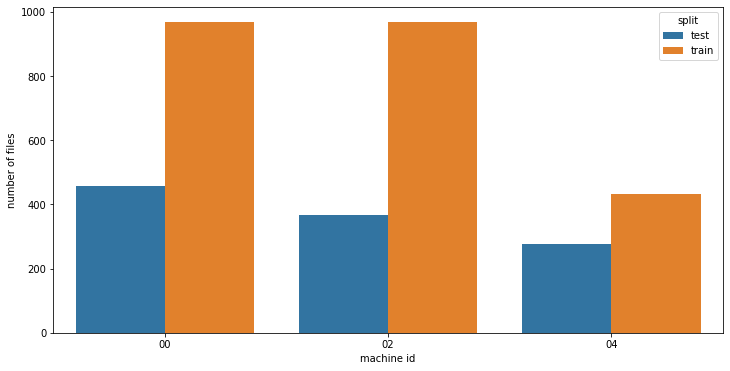

id      00         02         04      
split test train test train test train
file   456   968  367   968  278   434
type   456   968  367   968  278   434

In [4]:
# development dataset
DATA_ROOT=Path("dev_data/dev_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df = pd.DataFrame()
df['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df['type'] = df.file.map(lambda f: f.parent.parent.name)
df['split'] = df.file.map(lambda f: f.parent.name)
df['id'] = df.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

Machine types: ['slider']


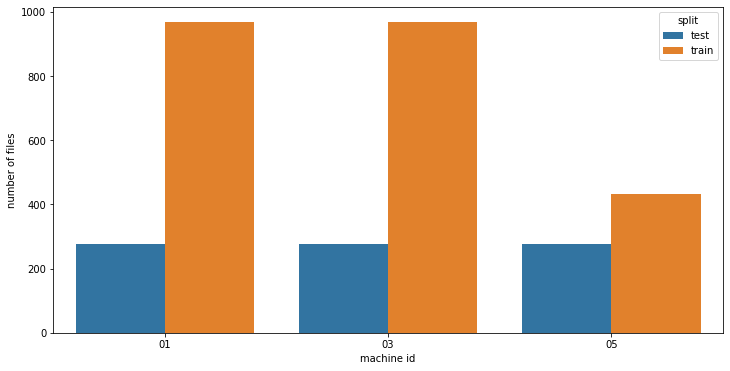

id      01         03         05      
split test train test train test train
file   278   968  278   968  278   434
type   278   968  278   968  278   434

In [5]:
# evaluation dataset
DATA_ROOT=Path("eval_data/eval_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df = pd.DataFrame()
df['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df['type'] = df.file.map(lambda f: f.parent.parent.name)
df['split'] = df.file.map(lambda f: f.parent.name)
df['id'] = df.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

In [6]:
df_train = df[df["split"] == 'train']
df_test = df[df["split"] == 'test']

print(f'Train set: {df_train.shape}')
print(f'Test set: {df_test.shape}')

Train set: (2370, 4)
Test set: (834, 4)


=== Machine type [slider], train set ===


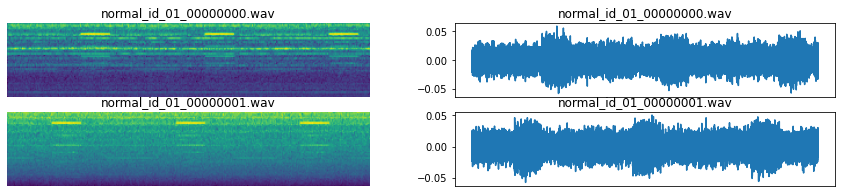

=== Machine type [slider], test set ===


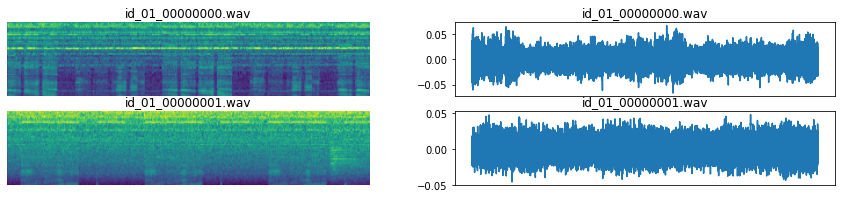

In [7]:
def get_log_mel_spectrogram(filename, n_mels=64,
                        n_fft=1024,
                        hop_length=512,
                        power=2.0):
    wav, sampling_rate = com.file_load(filename)
    mel_spectrogram = librosa.feature.melspectrogram(y=wav,
                                                     sr=sampling_rate,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
    return log_mel_spectrogram, wav

for t in types:
    for split in ['train', 'test']:
        type_df = df[df['type'] == t][df.split == split].reset_index()
        R = 2
        fig, ax = plt.subplots(R, 2, figsize = (15, 1.5*R))
        print(f'=== Machine type [{t}], {split} set ===')
        for i in range(R * 2):
            file_index = i//2
            file_path = Path(type_df.file[file_index])
            mels, wav = get_log_mel_spectrogram(file_path)
            if i%2==0:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].imshow(mels)
                ax[i//2, i%2].axis('off')
            else:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].plot(wav)
                ax[i//2, i%2].get_xaxis().set_ticks([])
        plt.show()

The raw audio file is a time-series data which indicates the amplitude of the sound over time (right figures). 

However, deep learning models rarely take this raw audio directly as input, the common practice is to convert the audio into a spectrogram (left figures). The spectrogram is a concise ‘snapshot’ of an audio wave and since it is an image, it is well suited to being input to CNN-based architectures developed for handling images. If you want to understand the audio spectrogram, this Audio Deep Learning [series](https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504) is very useful. In this notebook, we use the spectrogram as input.

### Comparing normal and abnormal sound

[]

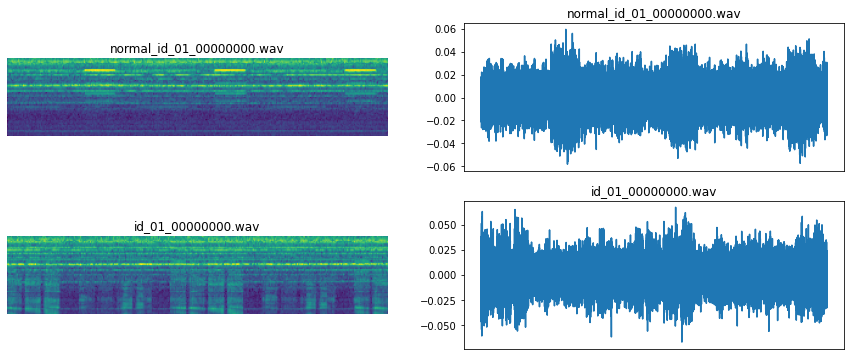

In [8]:
import soundfile as sf

#load a normal sound
normal_sound = df_train.file.iloc[0]
normal_signal, samplerate = sf.read(normal_sound)

#load an abnormal sound
abnormal_sound = df_test.file.iloc[0]
abnormal_signal, samplerate = sf.read(abnormal_sound)

fig, ax = plt.subplots(2, 2, figsize = (15, 3*2))
mels_n, wav_n = get_log_mel_spectrogram(normal_sound)
ax[0, 0].set_title(normal_sound.name)
ax[0, 0].imshow(mels_n)
ax[0, 0].axis('off')
ax[0, 1].set_title(normal_sound.name)
ax[0, 1].plot(wav_n)
ax[0, 1].get_xaxis().set_ticks([])

mels_a, wav_a = get_log_mel_spectrogram(abnormal_sound)
ax[1, 0].set_title(abnormal_sound.name)
ax[1, 0].imshow(mels_a)
ax[1, 0].axis('off')
ax[1, 1].set_title(abnormal_sound.name)
ax[1, 1].plot(wav_a)
ax[1, 1].get_xaxis().set_ticks([])

# Network


# CNN Autoencoder


In [11]:
"""
Thanks to https://github.com/daisukelab/dcase2020_task2_variants/blob/master/3cnn_ae_pytorch/model.py
for the code for this CNN AE.
"""

class CNNAE(nn.Module):
    def  __init__(self, z_dim=40, skip_connections = False):
        super().__init__()
        
        self.skip_connections = skip_connections

        # define the network
        # encoder
        self.conv1 = nn.Sequential(nn.ZeroPad2d((1,2,1,2)),
                              nn.Conv2d(1, 32, kernel_size=5, stride=2),
                              nn.ReLU())
        self.conv2 = nn.Sequential(nn.ZeroPad2d((1,2,1,2)),
                              nn.Conv2d(32, 64, kernel_size=5, stride=2),
                              nn.ReLU(), nn.Dropout(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
                              nn.ReLU(), nn.Dropout(0.3))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),
                              nn.ReLU(), nn.Dropout(0.3))
        self.fc1 = nn.Conv2d(256, z_dim, kernel_size=3)
        
        # decoder
        self.fc2 = nn.Sequential(nn.ConvTranspose2d(z_dim, 256, kernel_size=3),
                            nn.ReLU(), nn.Dropout(0.3))
        self.conv4d = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0),
                               nn.ReLU(), nn.Dropout(0.3))
        self.conv3d = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
                               nn.ReLU(), nn.Dropout(0.2))
        self.conv2d = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
                               nn.ReLU())
        self.conv1d = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2)
        
    def forward(self, x):
        if self.skip_connections:
            # x.shape (batch, 1, n_mels, n_mels )
            # encoder
            encoded = skip_1 = self.conv1(x)
            encoded = skip_2 = self.conv2(encoded)
            
            encoded = skip_3 = self.conv3(encoded)
            encoded = skip_4 = self.conv4(encoded)
            
            encoded = self.fc1(encoded)
            
            # decoder
            decoded = self.fc2(encoded)
            
            decoded = torch.cat([skip_4, decoded], dim=1)
            decoded = self.conv4d(decoded)
            
            decoded = torch.cat([skip_3, decoded], dim=1)
            decoded = self.conv3d(decoded)
           
            decoded = torch.cat([skip_2[:, :, :-1, :-1], decoded], dim=1)
            decoded = self.conv2d(decoded)            
            
            decoded = torch.cat([skip_1[:, :, :-1,:-1], decoded[:, :, 1:-1,1:-1]], dim=1)
            decoded = self.conv1d(decoded)[:,:,0:-1,0:-1]
            
            decoded = nn.Sigmoid()(decoded)
        else:
            # x.shape (batch, 1, n_mels, n_mels )
            encoded = self.conv1(x)
            encoded = self.conv2(encoded)
            encoded = self.conv3(encoded)
            encoded = self.conv4(encoded)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = self.conv4d(decoded)
            decoded = self.conv3d(decoded)
            decoded = self.conv2d(decoded)[:,:,1:-1,1:-1]
            decoded = self.conv1d(decoded)[:,:,0:-1,0:-1]

            decoded = nn.Sigmoid()(decoded)

        return decoded

### Parameters

In [12]:
params = {
# inout directory
"dev_directory" : "dev_data/dev_data",
"eval_directory" : "eval_data/eval_data",
"model_directory": "./model",
"result_directory": "./result",
"result_file": "result.csv",
"max_fpr" : 0.1,
"mode" : True, # mode=True for development dataset, mode=False for evaluation dataset

# preprocessing for mel-spectrogram
"feature": {
"n_mels": 128,
"frames" : 5,
"n_fft": 1024,
"hop_length": 512,
"power": 2.0,
"random": True,
"augment_tfm": None,
"augx": False,
"augy": False,
"debug": False,
"normalize": True},

# training
"fit":{
"lr": 0.01,
"b1": 0.9,
"b2": 0.999,
"weight_decay": 0.0,
"epochs" : 100,
"batch_size" : 500,
"shuffle" : True,
"validation_split" : 0.01,
"verbose" : 1},
    
# model architecture
"VAE":{
"x_dim": 640,
"h_dim": 200,
"z_dim": 20}
    
}
params = EasyDict(params)

# create working directory
ensure_folder(params.model_directory)

# test directories
dirs = com.select_dirs(param=params, mode=params.mode)

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(dirs)
slider_dir = dirs[0]
slider_dir

2024-01-07 13:46:01,676 - INFO - load_directory <- development


['C:\\Users\\Rea\\Desktop\\DataScience 3. Semestar\\Neuronske mreže\\Projekt Github\\NEUMREProj\\dev_data\\dev_data\\slider']


'C:\\Users\\Rea\\Desktop\\DataScience 3. Semestar\\Neuronske mreže\\Projekt Github\\NEUMREProj\\dev_data\\dev_data\\slider'

### CNNAE Training

In [13]:
def list_to_vector_array_CNN(file_list,
                             n_mels=64,
                            n_fft=1024,
                            hop_length=512,
                            power=2.0
                            ):
    
    for idx, file in enumerate(file_list):
        log_mel_spect, _ = get_log_mel_spectrogram(file,
                                                n_mels=n_mels,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                power=power)

        if idx == 0:  # first file
            dataset = np.zeros(
                (len(file_list), 
                log_mel_spect.shape[0],
                log_mel_spect.shape[1])
            )
            com.logger.info(f'Created the  dataset shape ({dataset.shape})')
            dataset[idx, ...] = log_mel_spect
        else:
            dataset[idx, ...], _ = get_log_mel_spectrogram(file,
                                            n_mels=n_mels,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)
    return dataset

In [14]:
class DatasetCNN(torch.utils.data.Dataset):
    """
    Thanks to https://github.com/daisukelab/dcase2020_task2_variants for most of this code.
    """
    def __init__(self,  files, n_mels, n_fft, hop_length, power,
                 n_sampling=10, transform=None, augment_tfm=None, normalize=True, 
                 random=True, aug_x=True, aug_y=False, debug=True):
        
        self.n_sampling = n_sampling
        self.files = files
        self.n_mels, self.n_fft = n_mels, n_fft
        self.hop_length, self.power = hop_length, power
        
        self.transform, self.augment_tfm = transform, augment_tfm
        self.random, self.aug_x, self.aug_y = random, aug_x, aug_y

        self.X = list_to_vector_array_CNN(self.files,
                                        n_mels=self.n_mels,
                                        n_fft=self.n_fft,
                                        hop_length=self.hop_length,
                                        power=self.power
                                        )
        
        if normalize:
            self.X = normalize_0to1(self.X)

        if debug:
            from dlcliche.utils import display
            from dlcliche.math import np_describe
            display(np_describe(self.X[0].cpu().numpy()))

        self.orgX = self.X
  
    def get_index_by_pct(self, split_pct=0.1):
        n = len(self.orgX)
        return random.sample(range(n), k=(n - int(n * split_pct)))

    def train_split(self, train_index):
        self.train_index = train_index
        self.X = self.orgX[train_index]
    
    def val_split(self, train_index):
        n = len(self.orgX)
        self.val_index = [i for i in range(n) if i not in train_index]
        self.X = self.orgX[self.val_index]
    
    def __len__(self):
        return len(self.X) * self.n_sampling

    def __getitem__(self, index):
        file_index = index // self.n_sampling
        part_index = index % self.n_sampling
        x = self.X[file_index]
        dim, length = x.shape

        # crop square part of sample
        if self.random:
            # random crop
            start = random.randint(0, length - dim)
        else:
            # crop with fixed position
            start = (length // self.n_sampling) * part_index
        start = min(start, length - dim)
        x = x[:, start:start+dim]

        # augmentation transform
        y = x
        if self.augment_tfm is not None:
            tfm_x = self.augment_tfm(x)
            if self.aug_x: x = tfm_x
            if self.aug_y: y = tfm_x

        # transform (convert to tensor here)
        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [15]:
def get_radius(dist: torch.Tensor, nu: float):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return np.quantile(np.sqrt(dist.clone().data.cpu().numpy()), 1 - nu)

def SVDD_loss_function(outputs, loss_objective, c, R, nu=0.1):
    """
    Params:
        recon_x: output of the VAE
        c: Hypersphere center
        loss_objective: 'one-class', 'soft-boundary'
        R: radius of the sphere
        
    """

    dist = torch.sum( (outputs - c) ** 2, dim=1)
    
    # Calculate L2 regularization term
    l2_regularization = 0.0
    for param in outputs.parameters():
        l2_regularization += torch.norm(param, p=2)

    # Add L2 regularization to the loss
    loss += l2_regularization * l2_reg

    if loss_objective == 'soft-boundary':
        scores = dist - R ** 2
        loss = R ** 2 + (1 / nu) * torch.mean(
            torch.max( torch.zeros_like(scores),scores)
            )
    else:
        loss = torch.mean(dist)
    
    # Update R
    if (loss_objective == 'soft-boundary'):
        R = torch.tensor(get_radius(dist, nu), device=device) # Device set global 

    return loss, R

In [16]:
total_loss = []
total_val_loss = []

# CNN Training class
class CNNTraining(pl.LightningModule):
    """Task2 PyTorch Lightning class, for training only."""

    def __init__(self, device, model, params, files, normalize=False):
        super().__init__()
        self.nu = None
        self.params = params
        self.lr = params.fit.lr
        self.normalize = normalize
        self.model = model
        self.mseloss = torch.nn.MSELoss()
        
        # split data files
        if files is not None:
            n_val = int(params.fit.validation_split * len(files))
            self.val_files = random.sample(files, n_val)
            self.train_files = [f for f in files if f not in self.val_files]
        
        if params.fit.nu is not None:
            self.R = torch.tensor(0.0, device=device)
            self.nu = params.fit.nu
            
            # GET CENTER
            dl = self.train_dataloader()
            self.c = self.init_center_c(dl, model, device)
    
    
    def init_center_c(self,
                      train_loader, 
                  net: nn.Module,
                  device, 
                  eps: float=0.1):
        """Initialize hypersphere center c as the mean from an initial forward pass on the data."""
    
        n_samples = 0
        net.eval()
        with torch.no_grad():
            for i, data in enumerate(train_loader):
                # get the inputs of the batch
                inputs, _ = data 
                # print(inputs.device)
                inputs = inputs.to(device)
                # print(inputs.device)
                outputs = net(inputs)
                outputs = outputs.to(device)
                # print(outputs.device, c.device)
                n_samples += outputs.shape[0]
                if i == 0:
                    c = torch.zeros(outputs.shape[1:], device=device)
                c += torch.sum(outputs, dim=0)

        c /= n_samples

        # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c
       

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        if self.nu is None:
            loss = self.mseloss(y_hat, y)
        else:
            loss, self.R = SVDD_loss_function(
                outputs = y_hat,
                loss_objective = 'soft-boundary',
                R = self.R,
                c = self.c,
                nu = self.nu
           )
        
        total_loss.append(float(loss))
        
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        #print(y.size()) #128
        #print(y_hat.size()) #144
        #print(x.size()) #128
        loss =  self.mseloss(y_hat, y)
        
        total_val_loss.append(float(loss))
        self.log("val_loss", float(loss))
        
        return {'val_loss': self.mseloss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),
                                lr=self.params.fit.lr,
                                betas=(self.params.fit.b1, self.params.fit.b2),
                                weight_decay=self.params.fit.weight_decay)
    
    def train_dataloader(self):
        com.logger.info('Creating Train')
        data_loader = self._get_dl('train')
        com.logger.info('End Train')
        return data_loader

    def val_dataloader(self):
        com.logger.info('Creating Val')
        data_loader = self._get_dl('val')
        com.logger.info('End Val')
        return data_loader
    
    
    def _get_dl(self, for_what):
        files = self.train_files if for_what == 'train' else self.val_files
        
        ds = DatasetCNN(files,
                        n_mels=self.params.feature.n_mels,
                        n_fft=self.params.feature.n_fft,
                        hop_length=self.params.feature.hop_length,
                        power=self.params.feature.power,
                        transform=ToTensor1ch(device=device, image=True),
                        random=self.params.feature.random,
                        augment_tfm=self.params.feature.augment_tfm,
                        aug_x=self.params.feature.augx,
                        aug_y=self.params.feature.augy,
                        debug=self.params.feature.debug,
                        normalize=self.params.feature.normalize)
    
        return torch.utils.data.DataLoader(ds,
                                           batch_size=self.params.fit.batch_size,
                                              shuffle=(self.params.fit.shuffle if for_what == 'train' else False)
                                          )

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

total_loss = []
total_val_loss = []
params.skip_connection = False # Add skip connections
params.feature.n_mels = 128 # Define size input (1, n_mels, n_mels)
params.fit.nu = None # None no SVDD, otherwise coefficient of the loss
params.fit.epochs = 100
params.fit.lr = 0.001
params.fit.batch_size = 64 

def train_cnnae():

    target='slider'
    
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')
    
    files = sorted(glob.glob(f'{slider_dir}/train/*.wav'))
    
    model = CNNAE(skip_connections = params.skip_connection).to(device)
    summary(device, model, input_size=(1, params.feature.n_mels, params.feature.n_mels))
    
    trainer = pl.Trainer(max_epochs=params.fit.epochs,
                         gpus=torch.cuda.device_count(),
                        callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
    
    task1 = CNNTraining(device, model, params, files, normalize = True)
    trainer.fit(task1)

    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task1.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')
    return task1
        
task1 = train_cnnae()

==== Start training [slider] with 0 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
             ReLU-12            [-1, 256, 7, 7]               0
          Dropout-13            [-1, 256, 7, 7]       

Sanity Checking: 0it [00:00, ?it/s]

2024-01-07 13:48:59,047 - INFO - Creating Val
2024-01-07 13:48:59,074 - INFO - Created the  dataset shape ((23, 128, 313))
2024-01-07 13:48:59,757 - INFO - End Val
2024-01-07 13:49:02,461 - INFO - Creating Train
2024-01-07 13:49:02,485 - INFO - Created the  dataset shape ((2347, 128, 313))
2024-01-07 13:50:16,255 - INFO - End Train


Training: 0it [00:00, ?it/s]